In [2]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot, CoV_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range
from utils.set_seed import setup_seed

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

src/username/data/NSC/data/dataset_L0_exp_set_0.h5


# Inference using the same validation dataset

get a observed sequence data x_o / seqC_o

In [51]:
DATA_PATH = adapt_path("~/tmp/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5")

# load the seqC_o from unseen dataset ['set_25']
with h5py.File(DATA_PATH, "r") as f:
    seqC_o = f['set_25']['seqC'][:]

x_o = seqC2x(seqC_o)
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S
print(f"==>> seqC_o.shape: {seqC_o.shape}")
print(f'{seqC_o[0,0,:3,:]=}')
print(f'{x_o[0,0,:3,:]=}')

==>> seqC_o.shape: (7, 3, 700, 15)
seqC_o[0,0,:3,:]=array([[ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2,  0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan]])
x_o[0,0,:3,:]=array([[0.5, 0.5, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.5, 0.5, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.5, 0.4, 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ]])


In [84]:
normed_limits = [[0,1], [0,1], [0,1], [0,1]]
# designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)
designed_limits = [[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]

# prepare varying theta values
print(f"designed_limits\n{designed_limits}")
print(f"normed_limits\n{normed_limits}")

ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"\n varying theta_values: \n{theta_values}")

designed_limits
[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
normed_limits
[[0, 1], [0, 1], [0, 1], [0, 1]]

 varying theta_values: 
[[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1

In [54]:
# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC_o,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)


--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 411600 with 16 workers ...



/tmp/ipykernel_3562239/1837682721.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 37392 tasks      | elapsed:    6.7s
[Parallel(n_jobs=16)]: Done 126992 tasks      | elapsed:   10.5s
[Parallel(n_jobs=16)]: Done 242192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 382992 tasks      | elapsed:   22.0s


time elapsed for simulation: 0.39 minutes
stacking the results
done stacking the results

seqC.shape: (7, 3, 700, 15), params.shape: (28, 4), probR.shape: (7, 3, 700, 28, 1)


[Parallel(n_jobs=16)]: Done 411600 out of 411600 | elapsed:   23.4s finished


In [55]:
probR.shape

(7, 3, 700, 28, 1)

In [57]:
prior_labels = ['$b$', '$\\sigma^2_a$', '$\\sigma^2_s$', '$\\lambda$']
chR = torch.tensor(probR).repeat_interleave(10, dim=-1)
chR = torch.bernoulli(chR)
chR = np.array(chR)

print(f"==>> x_o.shape: {x_o.shape}")
print(f"==>> seqC_o.shape: {x_o.shape}")
print(f"==>> probR.shape: {probR.shape}")
print(f"==>> chR.shape: {chR.shape}")

==>> x_o.shape: (7, 3, 700, 15)
==>> seqC_o.shape: (7, 3, 700, 15)
==>> probR.shape: (7, 3, 700, 28, 1)
==>> chR.shape: (7, 3, 700, 28, 10)


In [ ]:
# save using torch
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
torch.save(
    {
        "x_o": torch.tensor(x_o),
        "seqC_o": torch.tensor(seqC_o),
        "params": torch.tensor(params),
        "probR": torch.tensor(probR),
        "chR": torch.tensor(chR),
        "prior_labels": prior_labels,
        "normed_limits": torch.tensor(normed_limits),
        "designed_limits": torch.tensor(designed_limits),
    },
    valid_data_dir,
)

## Load prepared data

In [ ]:
# load the data
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
data = torch.load(valid_data_dir)
x_o = data["x_o"]
seqC_o = data["seqC_o"]
params = data["params"]
probR = data["probR"]
chR = data["chR"]
prior_labels = data["prior_labels"]
normed_limits = data["normed_limits"]
designed_limits = data["designed_limits"]
step = 7
num_params = 4
nT = 28
C_idx = 0
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S

# map 3, 5, 7, 9, 11, 13, 15
chosen_dur_list = np.array([3, 9, 15])
chosen_dur_idx = ((chosen_dur_list-3)/2).astype(int)

x_o_chosen_dur = x_o[chosen_dur_idx].reshape(-1, 15)
x_o_all = x_o.reshape(-1, 15)
print(f"==>> x_o_chosen_dur.shape: {x_o_chosen_dur.shape}")
print(f"==>> x_o_all.shape: {x_o_all.shape}")

prior_min = [-2.5,   0,  0,  -11]
prior_max = [ 2.5,  77, 18,   10]

## NPE Inference

load trained NPE model

In [5]:
pipeline_version = "p5a"
train_id = "train_L0_p5a"
exp_id = "p5a-conv_lstm-corr_conv-tmp-4"
log_exp_id = "npe-conv_lstm-mdn"

log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

config_file = log_dir / "config.yaml"
config = adapt_path(config_file)
with open(config, "r") as f:
    config = yaml.safe_load(f)
config_npe, model_path_npe = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver_npe, posterior_npe = get_posterior(
    model_path=model_path_npe,
    config=config_npe,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=False,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train/logs/train_L0_p5a/p5a-conv_lstm-corr_conv-tmp-4/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
conv_lstm

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets Loading 18 dataset into memory... 
['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24'] ... 0 2 4 6 8 10 12 14 16  finished in: 0.54s
dur of [3, 9, 15] are chosen, others are [removed] 
[seqC] shape: (18, 3, 3, 700, 15)
[theta] shape: (18, 500, 4)
[probR] shape: (18, 3, 3, 700, 500, 1)
==>> Further Sampling 20 times from probR (given 'in_dataset' process setting) ... in 0.03min
sampled chR shape torch.Size([18, 9, 7

check posterior with varying theta values

In [7]:
num_params = len(prior_labels)
all_samples = np.zeros((num_params, step - 2, 20_000, 4))
all_thetas = np.zeros((num_params, step - 2, 4))

for T in range(nT):
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue
    
    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1

    # == prepare the data for inference
    # = convert the theta to the normed range
    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    # = concat [x_o, chR]
    chR_test = chR[:, :, :, T, C_idx, None] # [D, M, S, 1]
    xy_test = torch.cat([x_o, chR_test], dim=-1) # [D, M, S, 16]
    xy_test = xy_test[chosen_dur_idx].reshape(-1, 16)
    
    samples = sampling_from_posterior(
        "cuda",
        posterior_npe,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_701683/3691419371.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()
/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm

In [8]:
xy_test

tensor([[0.5000, 0.5000, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.4000,  ..., 0.0000, 0.0000, 1.0000],
        [0.5000, 0.4000, 0.6000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.5000, 0.1000, 0.1000,  ..., 0.1000, 0.9000, 0.0000],
        [0.5000, 0.9000, 0.1000,  ..., 0.1000, 0.5000, 0.0000],
        [0.5000, 0.5000, 0.1000,  ..., 0.9000, 0.5000, 1.0000]],
       dtype=torch.float64)

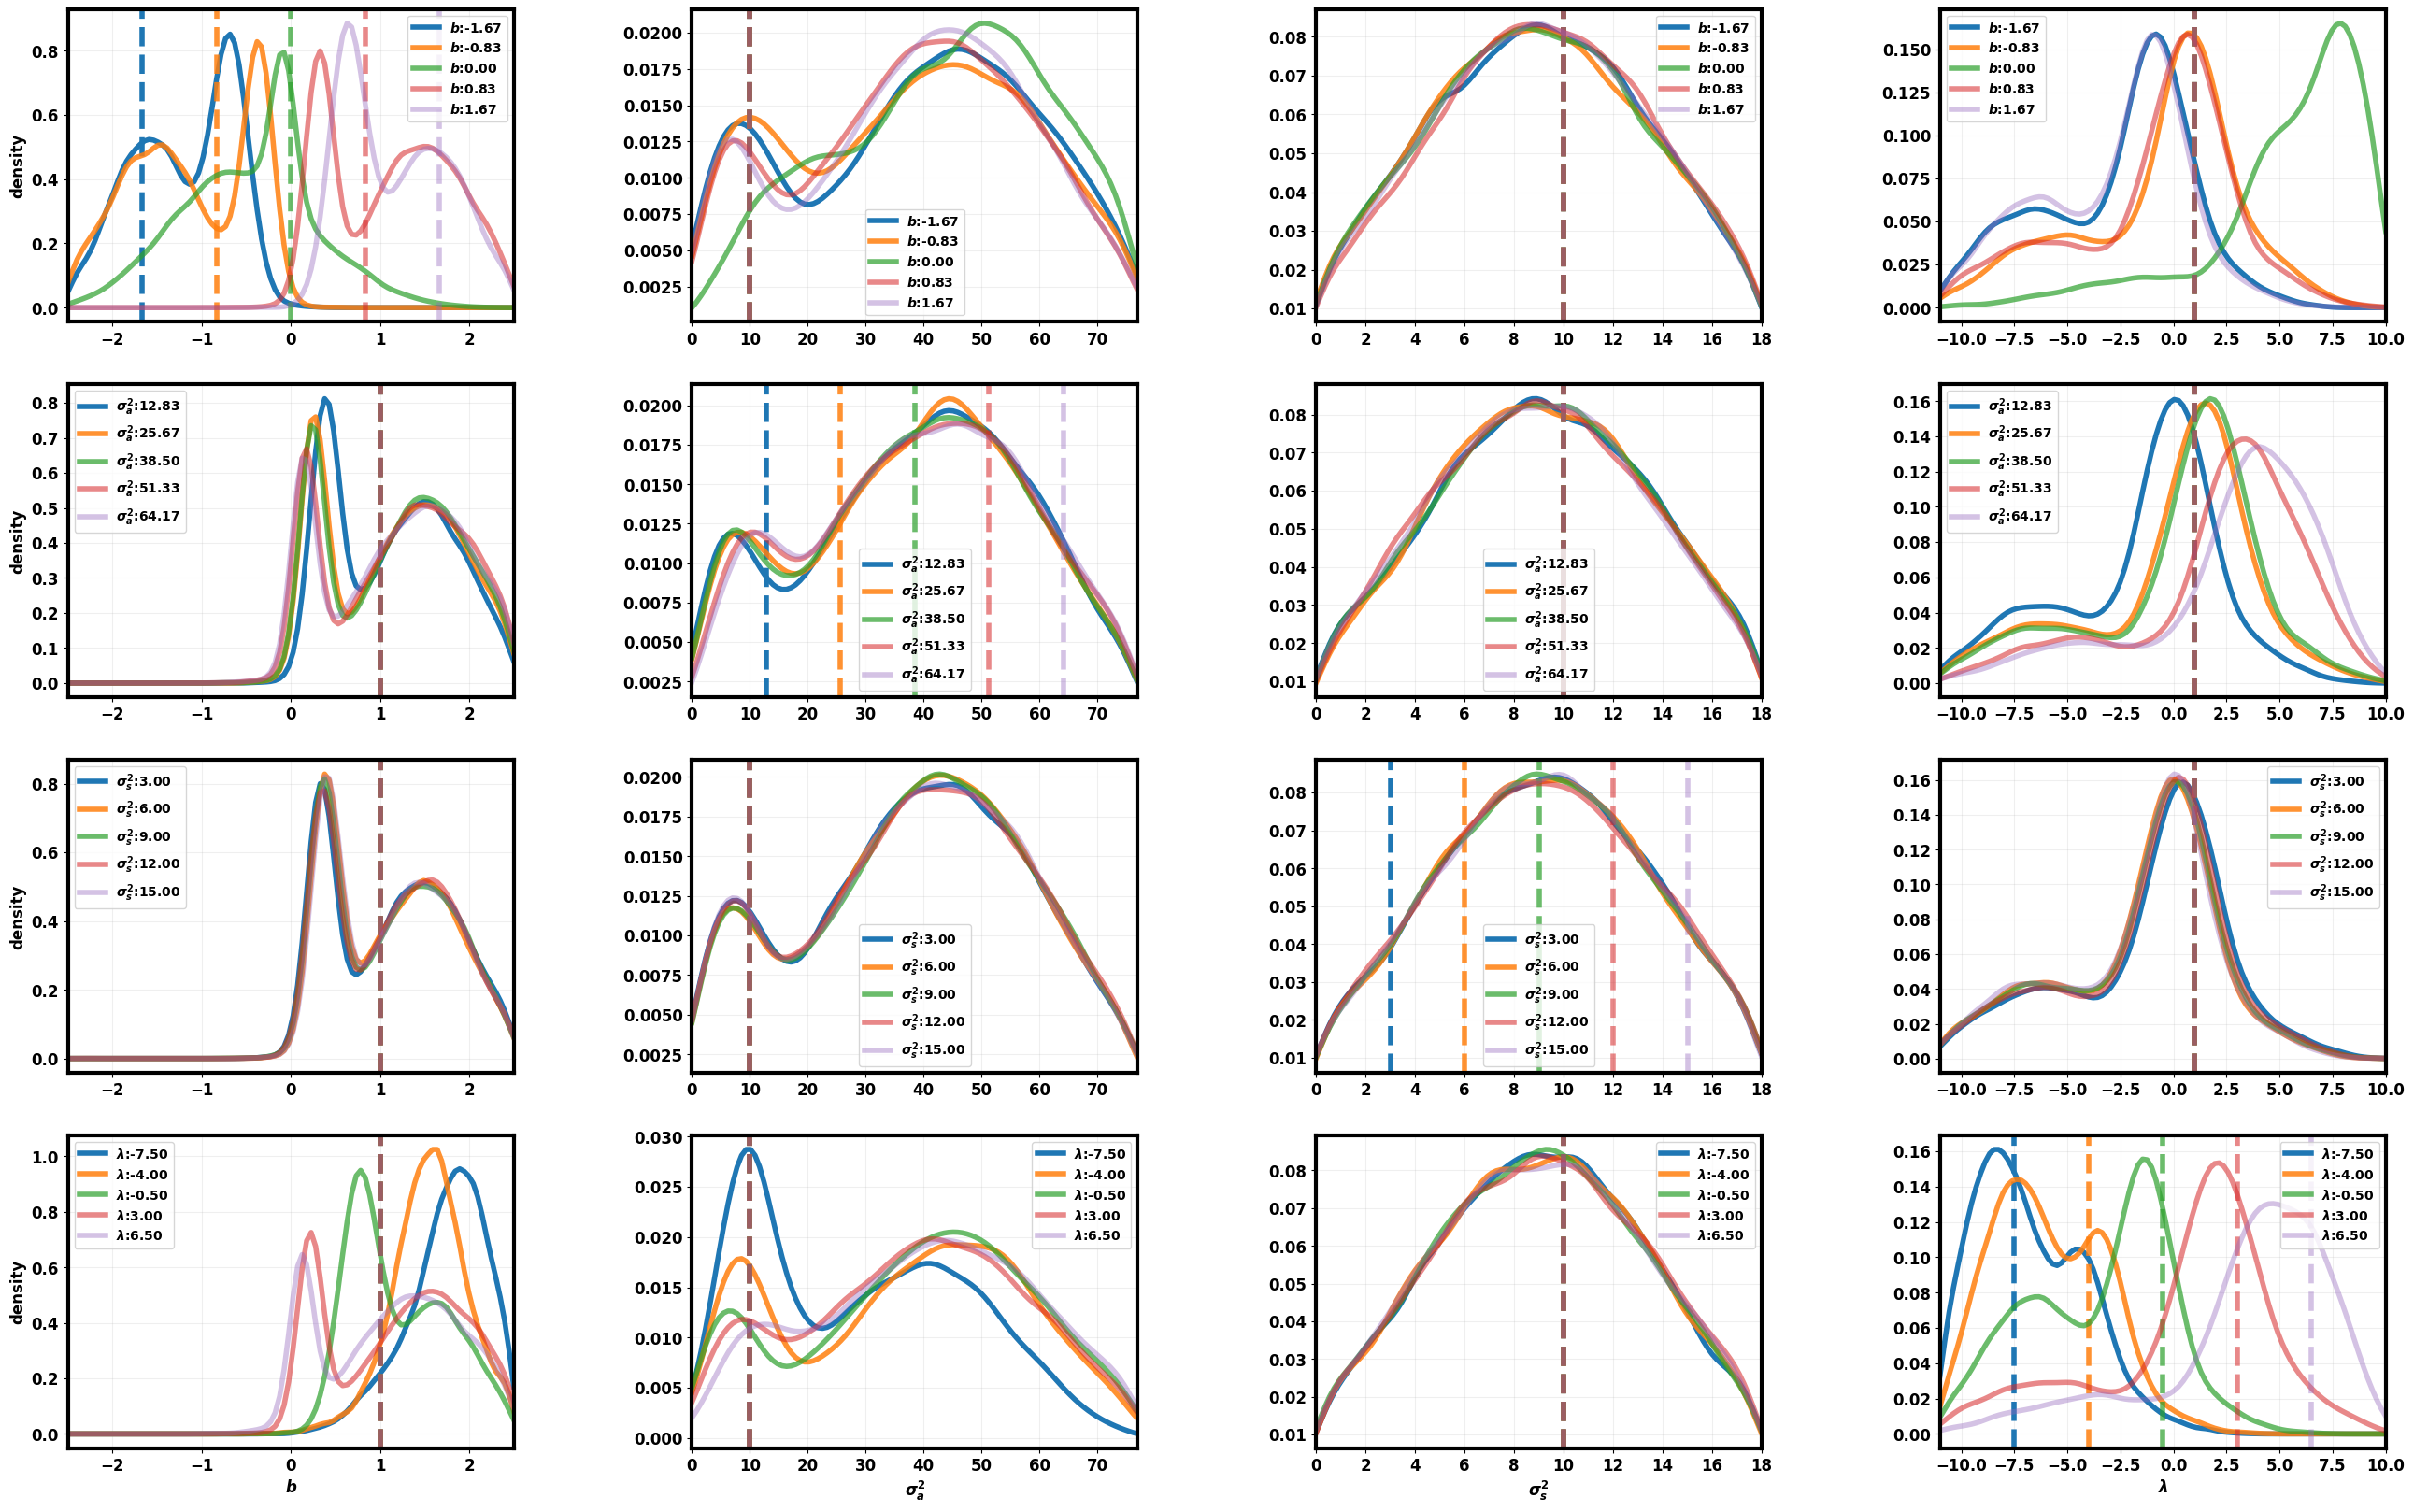

In [37]:
fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 8, 5 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            ax.plot(
                xs,
                ys,
                color=colors[k],
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            ax.axvline(
                all_thetas_dr[i, k, j],
                color=colors[k],
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)
            if j == 0:
                ax.set_ylabel("density")
        
        if i == num_params-1:
            ax.set_xlabel(prior_labels[j])

save_fig = fig_dir / 'compare' / f'{log_exp_id}-CoV.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## NPE-F Inference

In [12]:
# %% ==================================================
pipeline_version = "p4a"
train_id = "train_L0_p4a"
exp_id = "p4a-F1345-cnn-maf3"
# exp_id = "p4a-F1345-cnn"
log_exp_id = "npe-f-F1345-maf3"

# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

config_npef, model_path_npef = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver_npef, posterior_npef = get_posterior(
    model_path=model_path_npef,
    config=config_npef,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=False,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train/logs/train_L0_p4a/p4a-F1345-cnn-maf3/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
cnn

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets len_feature_each_type=[69, 15, 12, 56]
loading 18sets T100.00% C25...


100%|██████████| 18/18 [00:00<00:00, 35.67it/s]


dataset info: ==> self.total_samples=225000 => self.x.shape=torch.Size([18, 500, 25, 456, 1]) self.theta.shape=torch.Size([18, 500, 4])

[validation] sets len_feature_each_type=[69, 15, 12, 56]
loading 2sets T100.00% C25...


100%|██████████| 2/2 [00:00<00:00, 53.78it/s]

dataset info: ==> self.total_samples=25000 => self.x.shape=torch.Size([2, 500, 25, 456, 1]) self.theta.shape=torch.Size([2, 500, 4])
loader_kwargs={'batch_size': 20, 'drop_last': False, 'shuffle': True, 'pin_memory': False, 'num_workers': 4, 'worker_init_fn': <function seed_worker at 0x7efdb5ace9e0>, 'prefetch_factor': 2}

collect posterior sets... 

takes 0.62 seconds = 0.01 minutes

finished build network
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=8, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)

convert sequences of `all durations [3~15]` into feature vectors

In [13]:
chosen_features_lens = config_npef.dataset.feature_lengths
n_features = sum(chosen_features_lens)

Fs = torch.zeros((nT, n_features * M))

for T_idx in tqdm(range(nT)):
    chR_ = chR[:, :, :, T_idx, C_idx, None] # [D, M, S, 1]
    F = feature_extraction(seqC_o, chR_, config_npef)
    Fs[T_idx] = F

print(f"==>> Fs.shape: {Fs.shape}")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:18<00:00,  1.48it/s]

==>> Fs.shape: torch.Size([28, 456])


In [14]:
all_samples = np.zeros((4, step - 2, 20_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue

    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1
    
    # == prepare the data for inference
    # = convert the theta to the normed range
    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    F_test = Fs[T, :].unsqueeze(0).unsqueeze(-1).cuda()

    samples = sampling_from_posterior(
        "cuda",
        posterior_npef,
        F_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_485437/702609661.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()
/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)


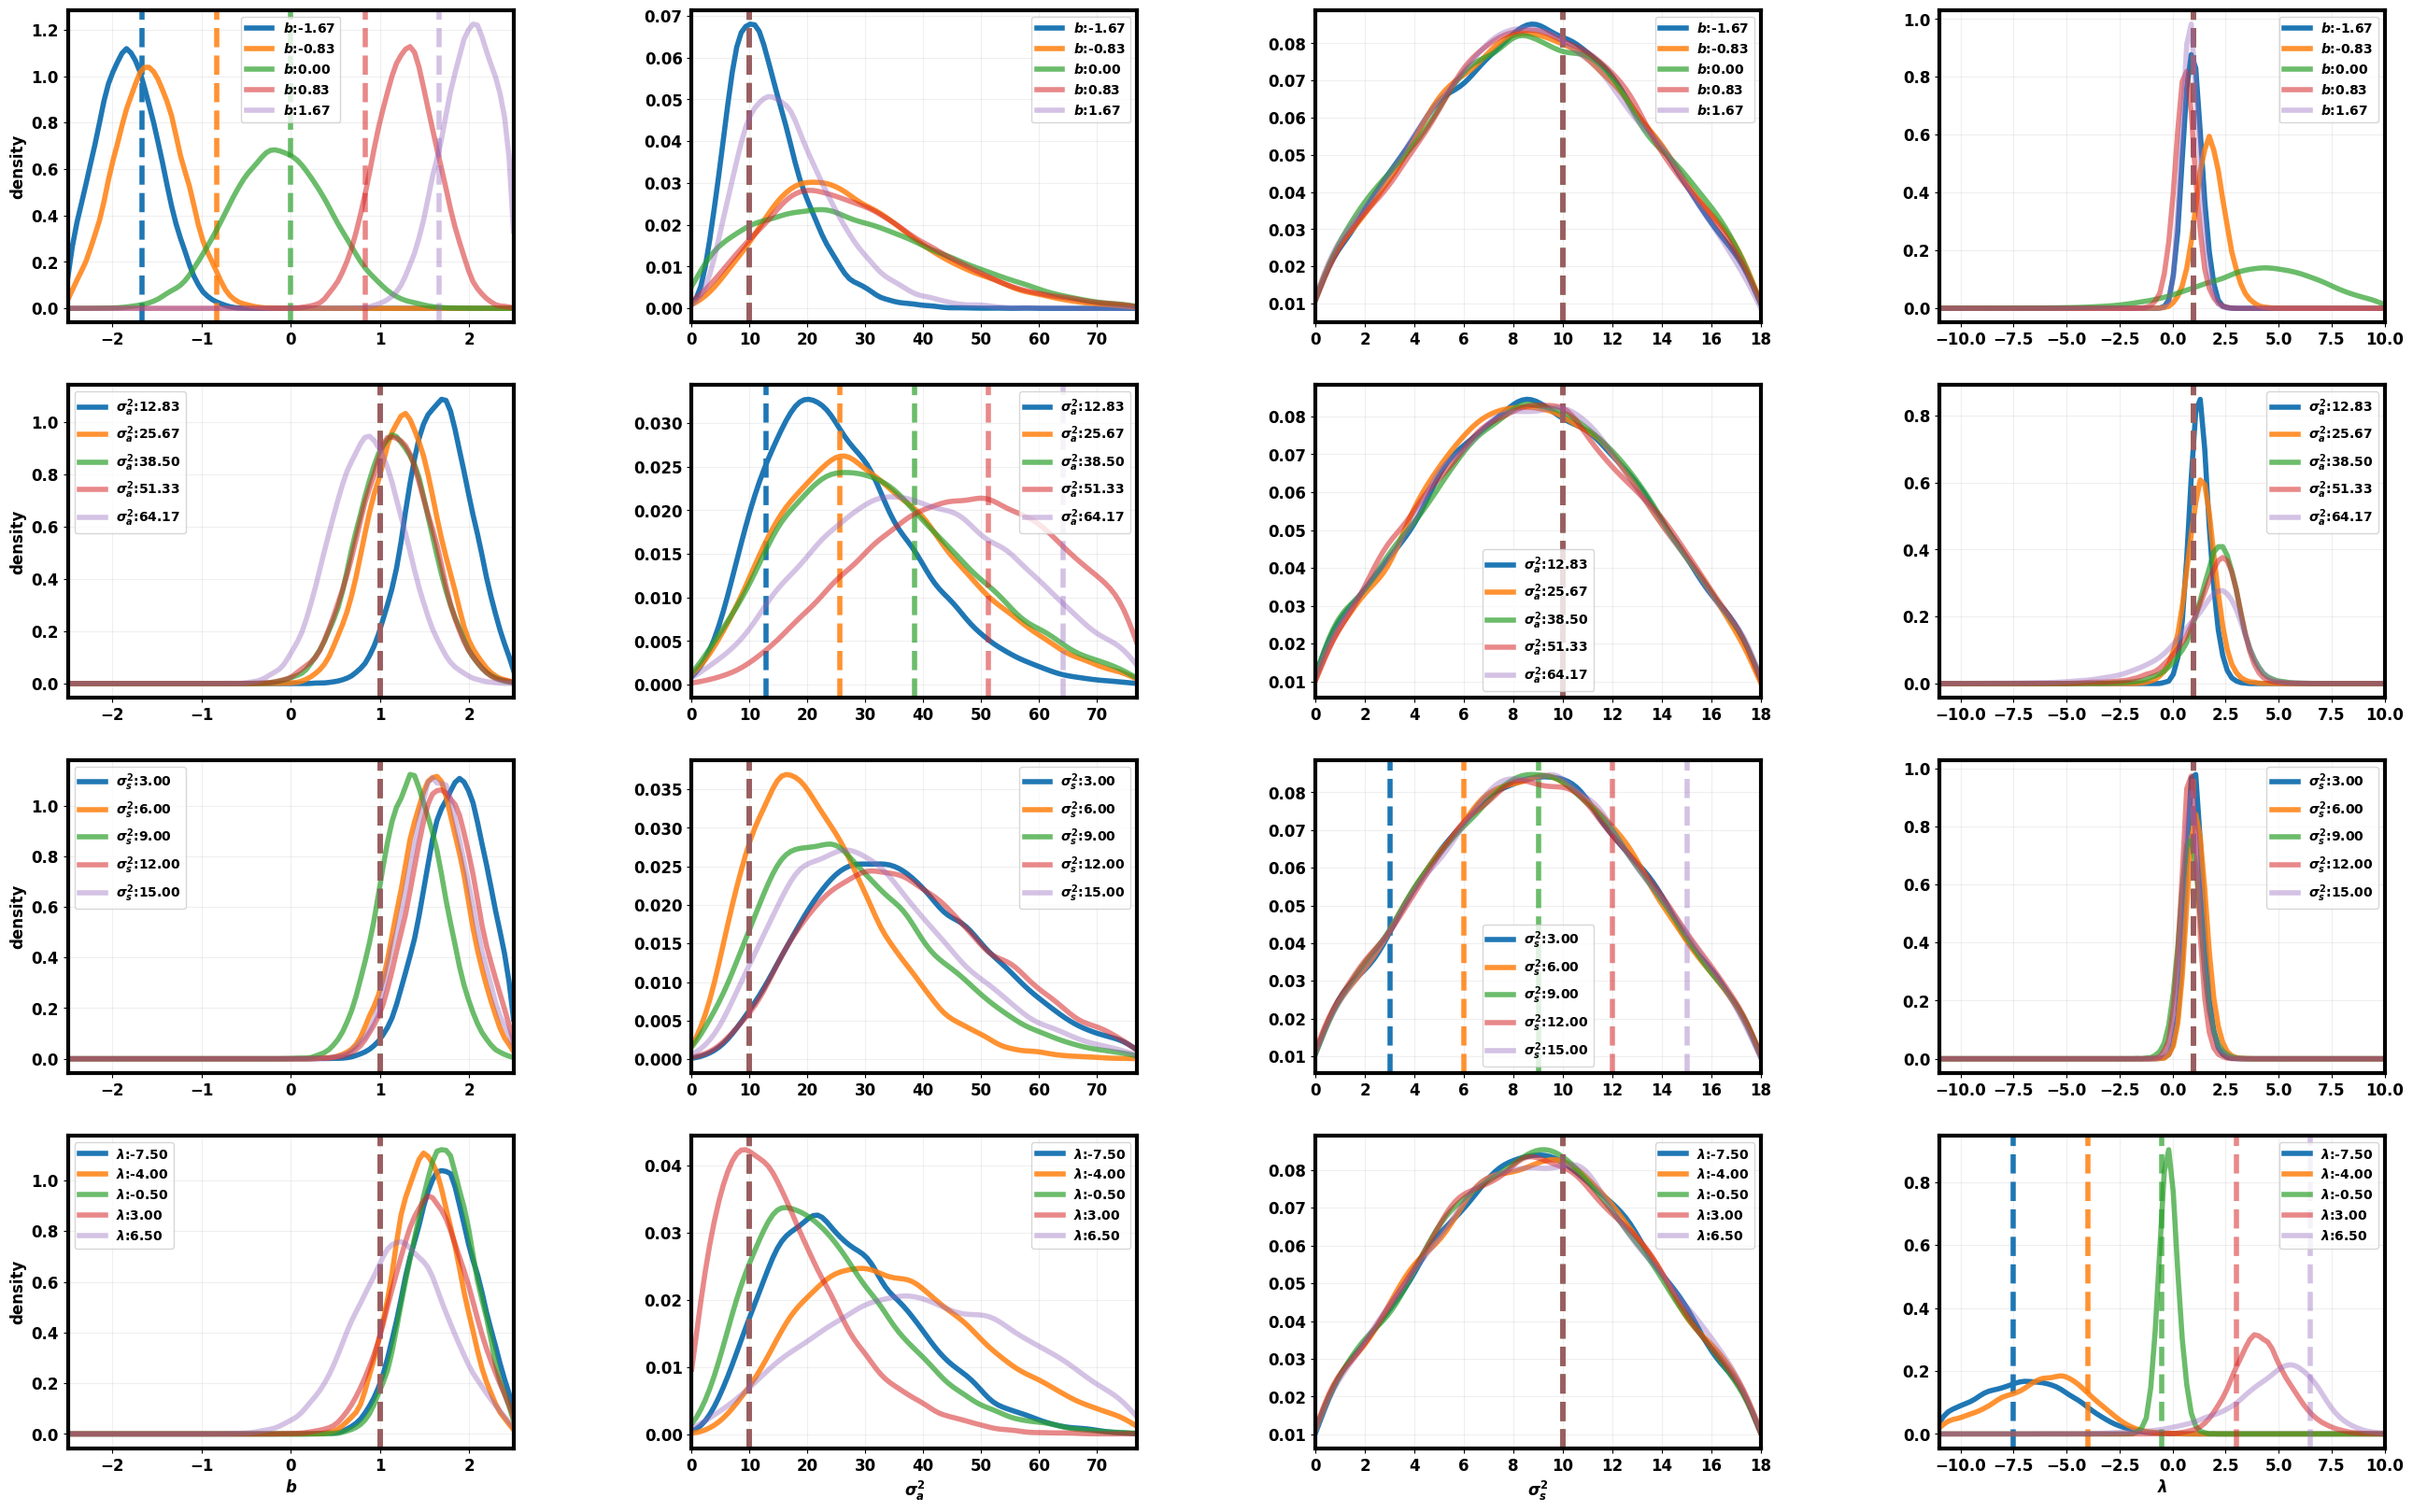

In [15]:
fig = CoV_plot(
    all_samples_dr,
    all_thetas_dr,
    num_params,
    designed_limits,
    prior_labels,
    colors,
)

save_fig = fig_dir / 'compare' / f'{log_exp_id}-CoV.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## NLE Inference

get likelihood estimator

In [3]:
# %% ==================================================
pipeline_version = "nle-p3"
train_id = "L0-nle-p3-cnn"
exp_id = "L0-nle-p3-cnn-newLoss"
log_exp_id = "nle-p3-cnn-newLoss"

# the computation is done in file: nle_inference.py

In [6]:
all_samples = np.zeros((4, step - 2, 2_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
# for T in [0]:
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue

    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1
    
    # == prepare the data for inference
    # = convert the theta to the normed range
    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    samples_dir = adapt_path(f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_all_dur_2k_T{T}.npy")
    samples = np.load(samples_dir)
    
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_551351/4236768006.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()


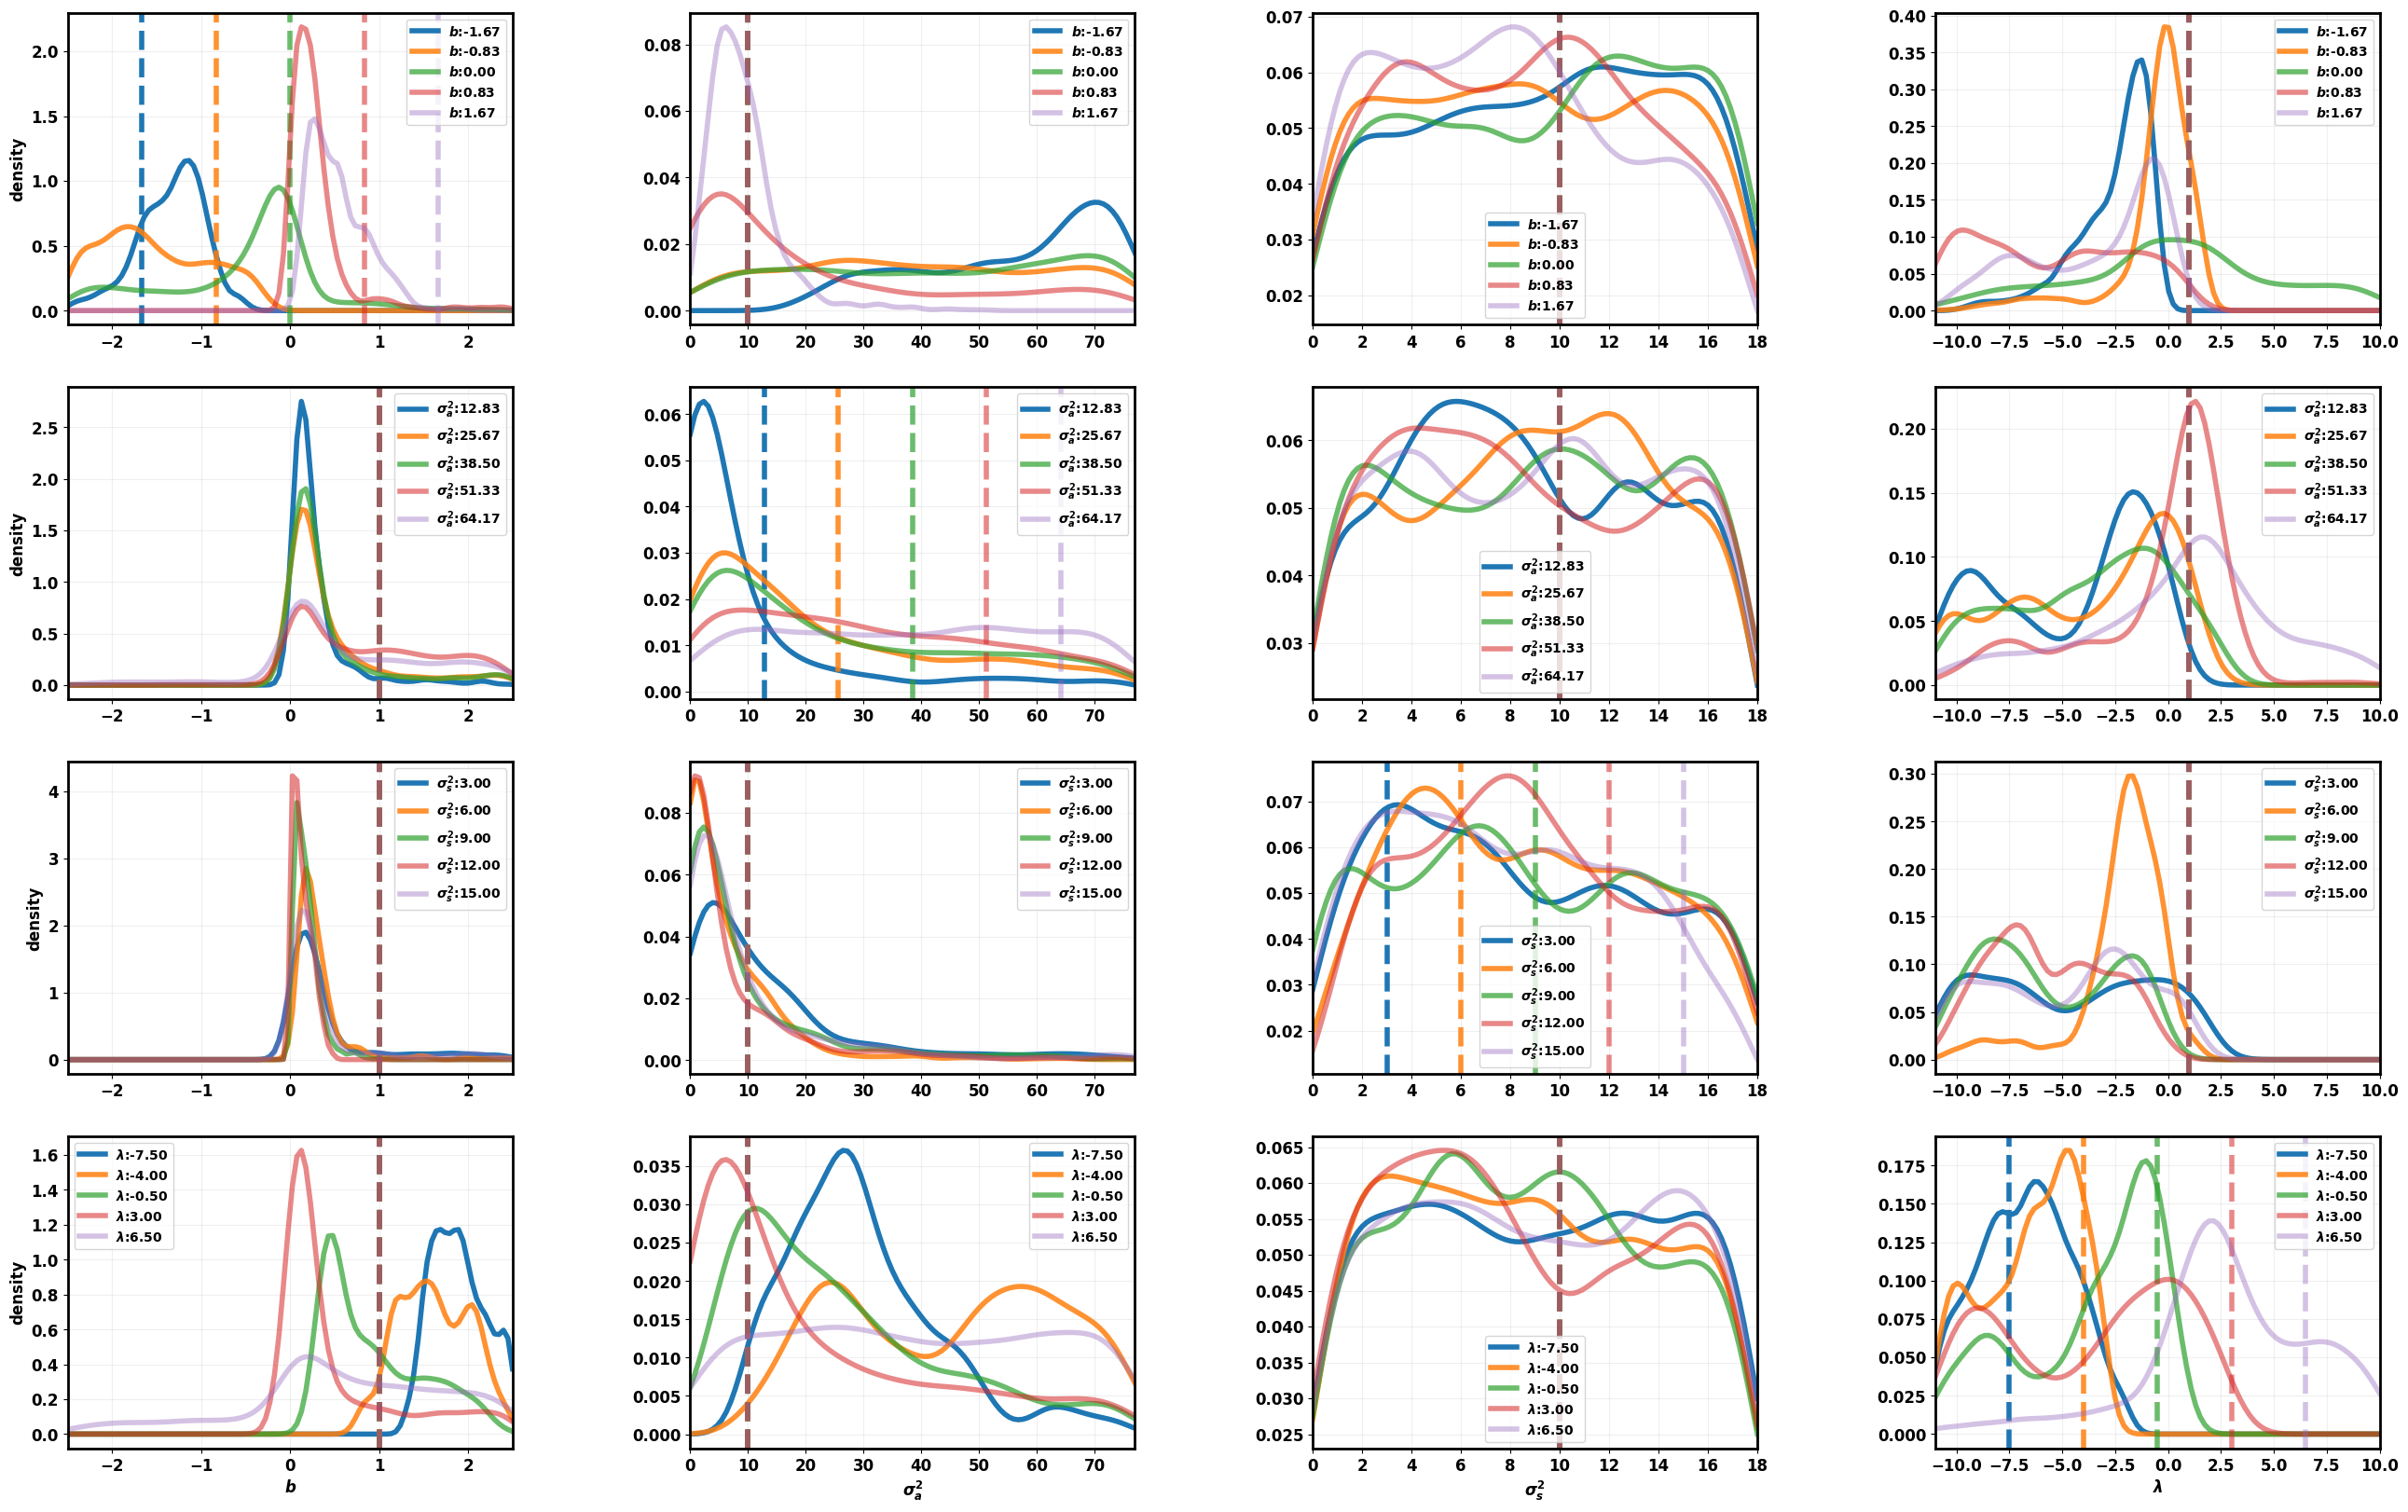

In [7]:
fig = CoV_plot(
    all_samples_dr,
    all_thetas_dr,
    num_params,
    designed_limits,
    prior_labels,
    colors,
)

save_fig = fig_dir / 'compare' / f'{log_exp_id}-CoV-chosen_dur-2k.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

# Inference On Subjects

## fitted data

In [3]:
exp_name = "fitted"
exps = [exp_name]

subj_IDs = np.arange(2, 13)
from utils.subject import get_fitted_param_L0
normed_limits = [[0,1], [0,1], [0,1], [0,1]]
designed_limits = [[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
dest_limits = designed_limits

# get fitted parameters
param_path = "~/data/NSC/data/params/263 models fitPars/"
param_path = adapt_path(param_path)
bias_fitted, sigma2a_fitted, sigma2s_fitted, L0_fitted = [], [], [], []
for subj_ID in subj_IDs:
    params_fitted = get_fitted_param_L0(param_path, subj_ID)
    bias_fitted.append(params_fitted[0])
    sigma2a_fitted.append(params_fitted[1])
    sigma2s_fitted.append(params_fitted[2])
    L0_fitted.append(params_fitted[3])
bias_fitted = np.array(bias_fitted)
sigma2a_fitted = np.array(sigma2a_fitted)
sigma2s_fitted = np.array(sigma2s_fitted)
L0_fitted = np.array(L0_fitted)

bias_s = [list(bias_fitted)]
sigma2a_s = [list(sigma2a_fitted)]
sigma2s_s = [list(sigma2s_fitted)]
L0_s = [list(L0_fitted)]

## NPE

In [4]:
import pickle
prior_labels = ['$b$', '$\sigma^2_a$', '$\sigma^2_s$', '$\lambda$']

exp_name = "npe-conv_lstm-mdn"
exps.append(exp_name)

exp_id = "train_L0_p5a/p5a-conv_lstm-corr_conv-tmp-4"
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / exp_id
inference_dir = log_dir / "inference"
# load pkl file
with open(inference_dir / "subj_thetas.pkl", "rb") as f:
    inference_subj = pickle.load(f)

# load parameters
bias_s.append([inference_subj[subj_ID][0] for subj_ID in subj_IDs])
sigma2a_s.append([inference_subj[subj_ID][1] for subj_ID in subj_IDs])
sigma2s_s.append([inference_subj[subj_ID][2] for subj_ID in subj_IDs])
L0_s.append([inference_subj[subj_ID][3] for subj_ID in subj_IDs])

### check posterior from samples

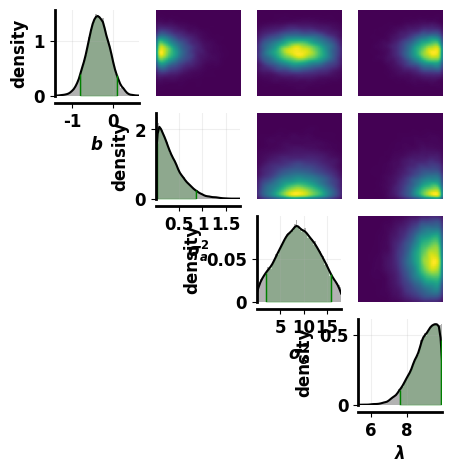

In [68]:
subj_ID = 2
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

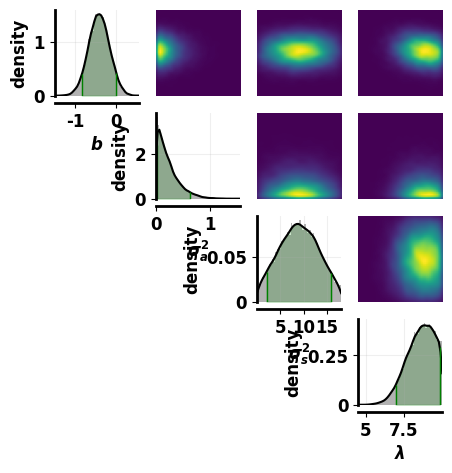

In [74]:
subj_ID = 4
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

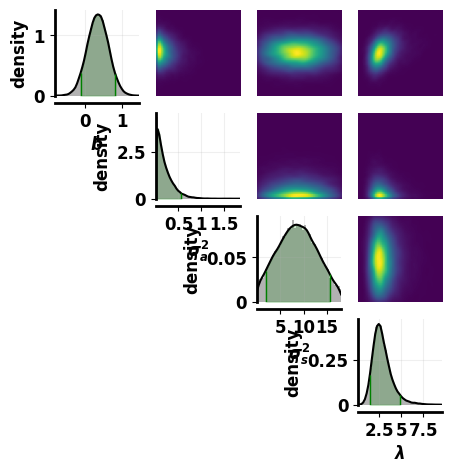

In [ ]:
subj_ID = 9
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

## FNPE

In [5]:
exp_name = "fnpe-maf3"
exps.append(exp_name)

exp_id = "train_L0_p4a/p4a-F1345-cnn-maf3"
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / exp_id
inference_dir = log_dir / "inference"
# load pkl file
with open(inference_dir / "subj_thetas.pkl", "rb") as f:
    inference_subj = pickle.load(f)

# load parameters
bias_s.append([inference_subj[subj_ID][0] for subj_ID in subj_IDs])
sigma2a_s.append([inference_subj[subj_ID][1] for subj_ID in subj_IDs])
sigma2s_s.append([inference_subj[subj_ID][2] for subj_ID in subj_IDs])
L0_s.append([inference_subj[subj_ID][3] for subj_ID in subj_IDs])

### check posterior from samples

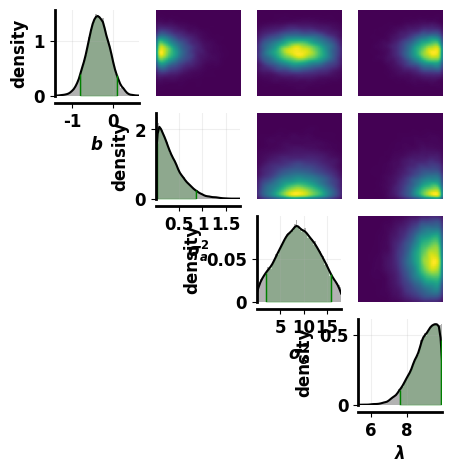

In [ ]:
subj_ID = 2
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

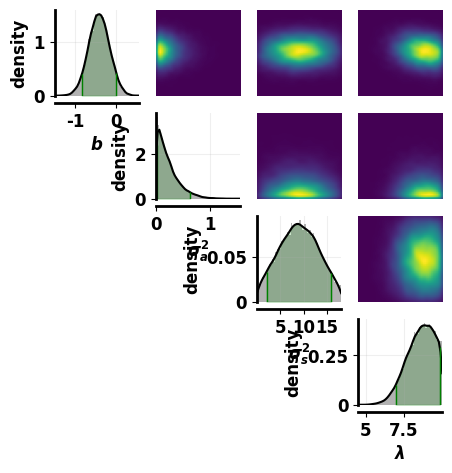

In [ ]:
subj_ID = 4
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

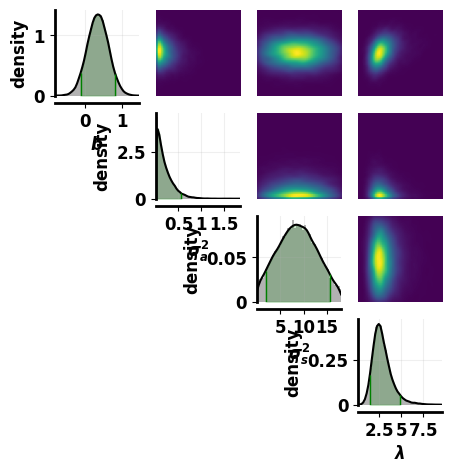

In [ ]:
subj_ID = 9
samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

## NLE

In [6]:
# load examples
from utils.inference import estimate_theta_from_post_samples


exp_name = "nle"
exps.append(exp_name)

exp_id = "L0-nle-p3-cnn/L0-nle-p3-cnn-newLoss"
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / exp_id
inference_dir = log_dir / "posterior"


estimates = []
for subj_ID in subj_IDs:
    samples = torch.load(inference_dir / f"samples_obs_Subject{subj_ID}.pt")
    samples = convert_samples_range(samples, normed_limits, designed_limits)

    estimate = estimate_theta_from_post_samples(dest_limits, samples, mode="mode")
    estimates.append(estimate)


for subj_ID in subj_IDs:
    bias_s.append([estimates[i][0] for i in range(len(subj_IDs))])
    sigma2a_s.append([estimates[i][1] for i in range(len(subj_IDs))])
    sigma2s_s.append([estimates[i][2] for i in range(len(subj_IDs))])
    L0_s.append([estimates[i][3] for i in range(len(subj_IDs))])

### check posterior from samples

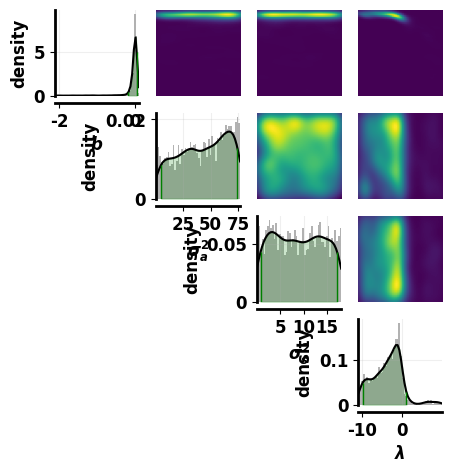

In [99]:
subj_ID = 2
# samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
samples = torch.load(inference_dir / f"samples_obs_Subject{subj_ID}.pt")
samples = convert_samples_range(samples, normed_limits, designed_limits)
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

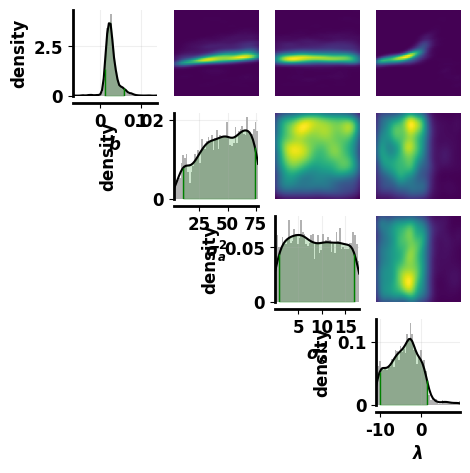

In [102]:
subj_ID = 4
# samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
samples = torch.load(inference_dir / f"samples_obs_Subject{subj_ID}.pt")
samples = convert_samples_range(samples, normed_limits, designed_limits)
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

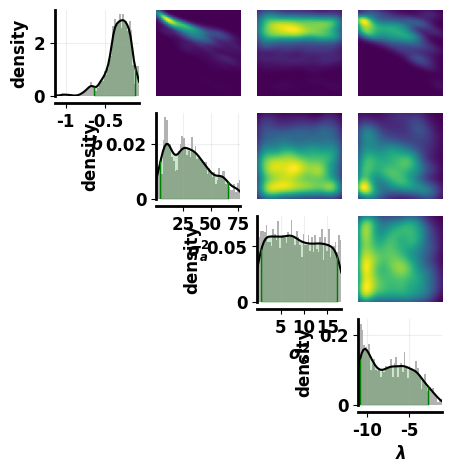

In [103]:
subj_ID = 9
# samples = pickle.load(open(inference_dir / f"samples_{subj_ID}.pkl", "rb"))
samples = torch.load(inference_dir / f"samples_obs_Subject{subj_ID}.pt")
samples = convert_samples_range(samples, normed_limits, designed_limits)
_ = pairplot(
    samples=samples,
    labels=prior_labels,
    diag="kde",
    upper='kde',
    figsize=(5, 5),
)

## Plot

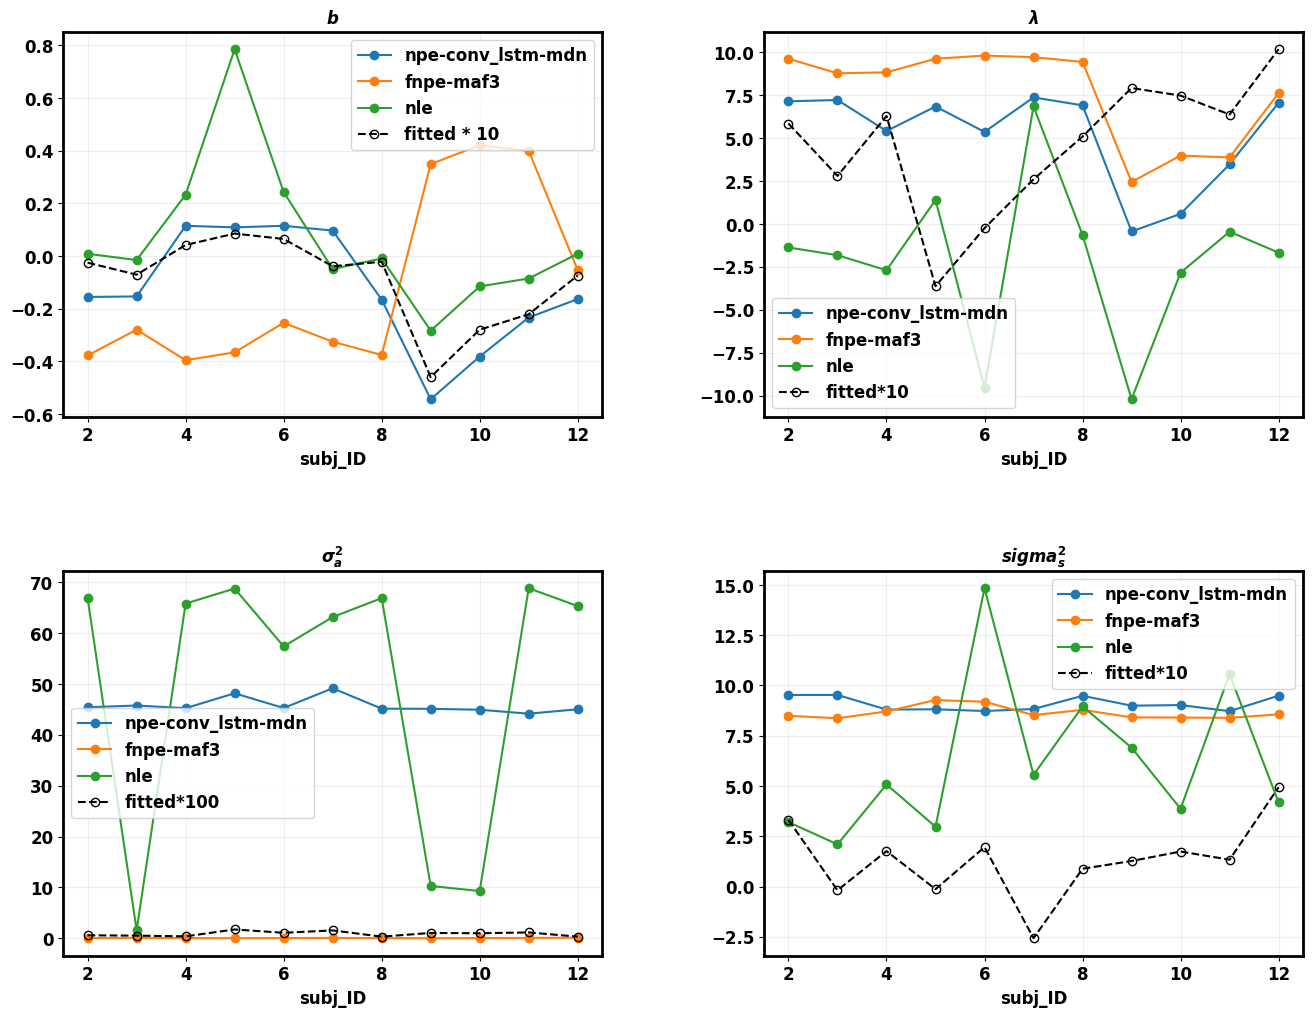

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# vertical space
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = axes[0, 0]
for exp in exps[1:]:
    ax.plot(subj_IDs, bias_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, bias_fitted * 10, "ko--", label="fitted * 10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("bias")
ax.set_title("$b$")
ax.grid(alpha=0.2)

ax = axes[0, 1]
for exp in exps[1:]:
    ax.plot(subj_IDs, L0_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, L0_fitted * 10, "ko--", label="fitted*10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("L0")
ax.set_title("$\lambda$")
ax.grid(alpha=0.2)

ax = axes[1, 0]
for exp in exps[1:]:
    ax.plot(subj_IDs, sigma2a_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, sigma2a_fitted * 100, "ko--", label="fitted*100", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("sigma2a")
ax.set_title("$\sigma^2_a$")
ax.grid(alpha=0.2)

ax = axes[1, 1]
for exp in exps[1:]:
    ax.plot(subj_IDs, sigma2s_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, sigma2s_fitted * 10, "ko--", label="fitted*10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("sigma2s")
ax.set_title("$sigma^2_s$")
ax.grid(alpha=0.2)

fig_path = adapt_path("~/data/NSC/codes/notebook/figures/compare/subjects-inferences.png")
plt.savefig(fig_path, dpi=300)

### check whether the prediction produce similar model output

In [25]:
from utils.inference import estimate_theta_from_post_samples
from simulator.seqC_generator import seqC_generator
from simulator.DM_model import DM_model
model_name = 'B-G-L0S-O-N-'
def simulate_model(params, seqC):
    model = DM_model(params=params, model_name=model_name)
    a, probR = model.simulate(seqC)
    return a, probR

probR_collect = []
a_collect = []
ID_collect = []

print(exps)
setup_seed(1)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.8],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC}")

for subj_ID in np.arange(2, 13):
    
    bias_fitted = bias_s[0][np.where(subj_IDs==subj_ID)[0][0]]
    bias_npe =  bias_s[1][np.where(subj_IDs==subj_ID)[0][0]]
    bias_fnpe =  bias_s[2][np.where(subj_IDs==subj_ID)[0][0]]
    bias_nle =  bias_s[3][np.where(subj_IDs==subj_ID)[0][0]]

    sigma2a_fitted = sigma2a_s[0][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2a_npe =  sigma2a_s[1][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2a_fnpe =  sigma2a_s[2][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2a_nle =  sigma2a_s[3][np.where(subj_IDs==subj_ID)[0][0]]

    sigma2s_fitted = sigma2s_s[0][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2s_npe =  sigma2s_s[1][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2s_fnpe =  sigma2s_s[2][np.where(subj_IDs==subj_ID)[0][0]]
    sigma2s_nle =  sigma2s_s[3][np.where(subj_IDs==subj_ID)[0][0]]

    L0_fitted = L0_s[0][np.where(subj_IDs==subj_ID)[0][0]]
    L0_npe =  L0_s[1][np.where(subj_IDs==subj_ID)[0][0]]
    L0_fnpe =  L0_s[2][np.where(subj_IDs==subj_ID)[0][0]]
    L0_nle =  L0_s[3][np.where(subj_IDs==subj_ID)[0][0]]

    params_fitted = np.array([bias_fitted, sigma2a_fitted, sigma2s_fitted, L0_fitted])
    params_npe = np.array([bias_npe, sigma2a_npe, sigma2s_npe, L0_npe])
    params_fnpe = np.array([bias_fnpe, sigma2a_fnpe, sigma2s_fnpe, L0_fnpe])
    params_nle = np.array([bias_nle, sigma2a_nle, sigma2s_nle, L0_nle])

    a_fitted, probR_fitted = simulate_model(params_fitted, seqC)
    a_npe, probR_npe = simulate_model(params_npe, seqC)
    a_fnpe, probR_fnpe = simulate_model(params_fnpe, seqC)
    a_nle, probR_nle = simulate_model(params_nle, seqC)

    a_collect.append([a_fitted[-1], a_npe[-1], a_fnpe[-1], a_nle[-1]])
    probR_collect.append([probR_fitted, probR_npe, probR_fnpe, probR_nle])
    ID_collect.append(subj_ID)

['fitted', 'npe-conv_lstm-mdn', 'fnpe-maf3', 'nle']

--- generated seqC info ---
dur_list: [9]
MS_list: [0.8]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [[[[0.  0.  0.8 0.  0.  0.  0.  0.  0.8 nan nan nan nan nan nan]]]]


In [189]:
params_fitted

array([-0.00736989,  0.00342664,  0.49401001,  1.01768512])

In [190]:
params_npe

array([-0.16306523, 45.01680672,  9.49339736,  7.05882353])

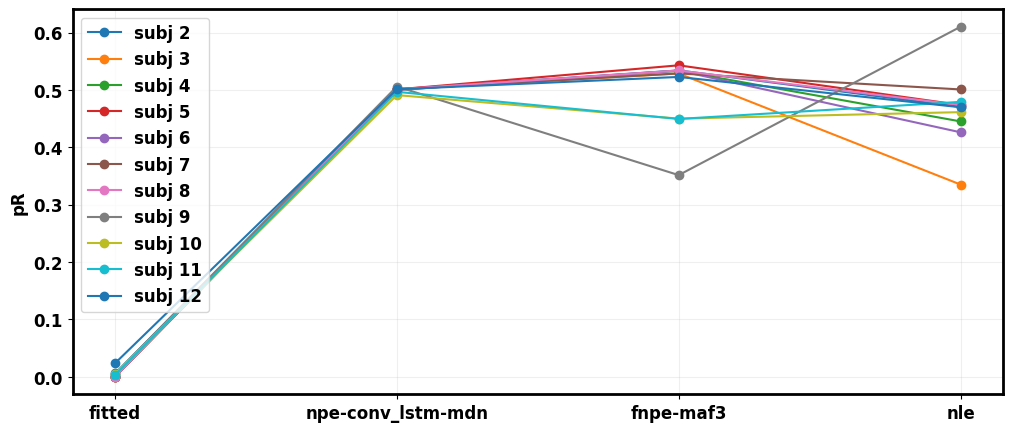

In [192]:
fig = plt.subplots(figsize=(12, 5))
for i, subj_ID in enumerate(ID_collect):
    plt.plot(probR_collect[i], 'o-', label=f'subj {subj_ID}')

plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xticks(np.arange(4), exps)
plt.ylabel('pR')

fig_path = adapt_path("~/data/NSC/codes/notebook/figures/compare/simulator-result-0.png")
plt.savefig(fig_path, dpi=300)

In [142]:
bias_s[0]

[-0.002485426702904376,
 -0.0070461599669531015,
 0.004210473922492048,
 0.008561713795704109,
 0.006504039006997041,
 -0.0038513728638885237,
 -0.002146587622618618,
 -0.045923118332278225,
 -0.02792452400618412,
 -0.02206160065981221,
 -0.007369885314735883]

In [145]:
sigma2a_s[0]

[0.006051444658619511,
 0.0053745377044266355,
 0.003972325174010418,
 0.017490277340381652,
 0.010993971531916669,
 0.015662444935651575,
 0.0033858007164485407,
 0.01070284586715205,
 0.010058246742641651,
 0.011660837922213813,
 0.0034266424797672257]

In [146]:
sigma2s_s[0]

[0.3313038239656285,
 -0.018656883584579884,
 0.17624301889277044,
 -0.013039179888748713,
 0.1957562323882837,
 -0.25710308817405775,
 0.08845307881905,
 0.12697161456941697,
 0.17406503647862526,
 0.13354055307183277,
 0.4940100125347714]

In [147]:
L0_s[0]

[0.5848531021475448,
 0.27969743269556985,
 0.6285579093748846,
 -0.36250574697054805,
 -0.024383164920284653,
 0.2598574950693119,
 0.5090415350974052,
 0.7917234439738656,
 0.7475250237601917,
 0.6373370691927391,
 1.0176851208915927]

## check pR distribution in the dataset

In [15]:
import h5py
data_dir = "/home/wehe/data/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5"

with h5py.File(data_dir, "r") as f:
    probRs = []
    for i in range(18):
        probR = f[f'set_{i}']["probR"][:]
        probRs.append(probR)

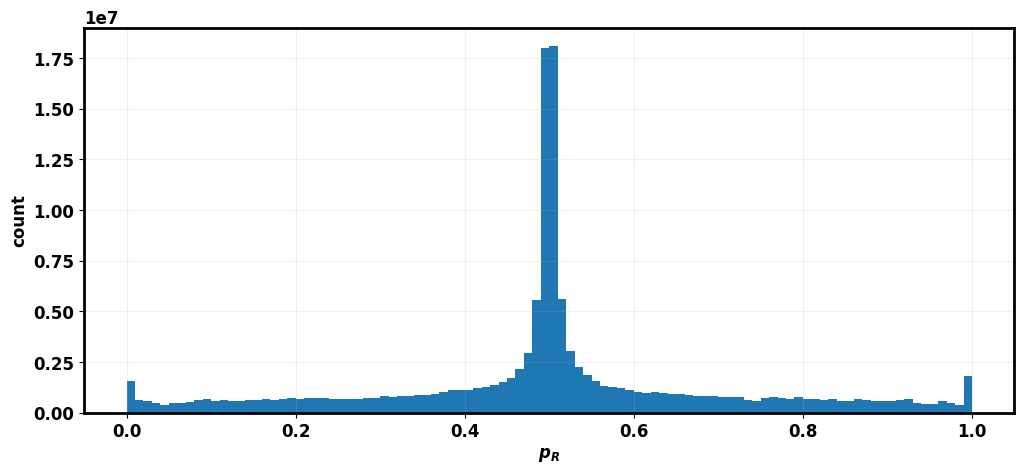

In [23]:
probR = np.array(probRs).reshape(-1)
fig = plt.figure(figsize=(12, 5))
_ = plt.hist(probR, bins=100)
plt.grid(alpha=0.2)
plt.xlabel('$p_R$')
plt.ylabel('count')

save_fig = fig_dir / 'compare' / f'pR-hist.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)